# BitFEAR: Time Series Analysis

Experimental analysis and learning using:

* Tweets containing #bitcoin, with Vader sentiment scores
* Tweet volume for #bitcoin
* Google Trends data
* Deribit Bitcoin Options orderbook data
* Bitcoin price data

In [1]:
%config IPCompleter.greedy=True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
plt.rcParams["figure.figsize"] = (16, 10)

### Getting tweets from Google Cloud Storage

In [4]:
from google.cloud import firestore
import json

In [5]:
db = firestore.Client()
tweets_ref = db.collection('tweet_data_#bitcoin')

def count_collection(coll_ref, count, cursor=None):

    if cursor is not None:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").start_after(cursor).stream()]
    else:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").stream()]

    count = count + len(docs)
    tweet_docs.append(docs)

    if len(docs) == 1000:
        return count_collection(coll_ref, count, docs[999].reference.get())
    else:
        print(count)

Load tweets from saved CSV

In [7]:
bkp_tweets_df = pd.read_csv('tweets.csv')
bkp_tweets_df['created'] = pd.to_datetime(bkp_tweets_df['created'])
bkp_tweets_df

,created,tweet_id,user_id,compound
0,2020-03-09 19:43:06+00:00,1237101627925987329,116270443,0.0000
1,2020-03-09 19:43:20+00:00,1237101685757087744,2372242398,0.4926
2,2020-03-09 19:43:26+00:00,1237101710935392256,1075804135524585473,0.4926
3,2020-03-09 19:43:30+00:00,1237101728488718336,877210351301001216,0.0000
4,2020-03-09 19:43:32+00:00,1237101736650661888,1153377427034259457,0.4019
...,...,...,...,...
430379,2020-05-11 17:08:22+00:00,1259893121086824455,628352957,-0.2263
430380,2020-05-11 17:08:24+00:00,1259893127793577984,1246430585150676995,0.0000
430381,2020-05-11 17:08:38+00:00,1259893189130911753,136770654,0.0000
430382,2020-05-11 17:08:39+00:00,1259893192763285506,898520034716385280,0.7424


In [9]:
tweet_last_id = bkp_tweets_df['tweet_id'].iloc[-1]
tweet_last = tweets_ref.where('tweet_id', '==', f'{tweet_last_id}').stream()
for tweet in tweet_last:
    tweet_last_ref = tweet.reference.get()

Get tweets since last saved tweet from Firestore

In [10]:
tweets = list()
tweet_docs = list()

count_collection(tweets_ref, 0, tweet_last_ref)

74376


In [11]:
tweets = [item.to_dict() for sublist in tweet_docs for item in sublist]

new_tweets_df = pd.DataFrame(tweets)
new_tweets_df['compound'] = pd.json_normalize(new_tweets_df['sentiment_scores'])['compound']
new_tweets_df = new_tweets_df.filter(['created', 'tweet_id', 'user_id', 'compound'])
new_tweets_df

,created,tweet_id,user_id,compound
0,2020-05-11 17:08:52+00:00,1259893247054426113,1063046445996085249,-0.5399
1,2020-05-11 17:08:52+00:00,1259893248186814464,998974569213038594,0.8402
2,2020-05-11 17:08:53+00:00,1259893252133715971,1255608578062286848,0.8126
3,2020-05-11 17:08:54+00:00,1259893255686127633,1306079407,0.6249
4,2020-05-11 17:08:56+00:00,1259893263844196354,2366685349,0.0516
...,...,...,...,...
74371,2020-05-19 22:19:51+00:00,1262870610243444737,933414046749155329,-0.5719
74372,2020-05-19 22:19:55+00:00,1262870629625352192,54947211,0.4215
74373,2020-05-19 22:20:09+00:00,1262870687179436032,1261073775723831296,0.7418
74374,2020-05-19 22:20:42+00:00,1262870823741919234,2242401187,0.0000


In [12]:
tweets_df = pd.concat([bkp_tweets_df, new_tweets_df], ignore_index=True).sort_index()
tweets_df

,created,tweet_id,user_id,compound
0,2020-03-09 19:43:06+00:00,1237101627925987329,116270443,0.0000
1,2020-03-09 19:43:20+00:00,1237101685757087744,2372242398,0.4926
2,2020-03-09 19:43:26+00:00,1237101710935392256,1075804135524585473,0.4926
3,2020-03-09 19:43:30+00:00,1237101728488718336,877210351301001216,0.0000
4,2020-03-09 19:43:32+00:00,1237101736650661888,1153377427034259457,0.4019
...,...,...,...,...
504755,2020-05-19 22:19:51+00:00,1262870610243444737,933414046749155329,-0.5719
504756,2020-05-19 22:19:55+00:00,1262870629625352192,54947211,0.4215
504757,2020-05-19 22:20:09+00:00,1262870687179436032,1261073775723831296,0.7418
504758,2020-05-19 22:20:42+00:00,1262870823741919234,2242401187,0.0000


Update CSV

In [13]:
tweets_df.to_csv('tweets.csv', index=False)

### Calculate tweet volume

In [14]:
tweets_time_df = tweets_df.set_index('created').filter(['tweet_id', 'compound'])
tweets_time_df

,tweet_id,compound
created,,
2020-03-09 19:43:06+00:00,1237101627925987329,0.0000
2020-03-09 19:43:20+00:00,1237101685757087744,0.4926
2020-03-09 19:43:26+00:00,1237101710935392256,0.4926
2020-03-09 19:43:30+00:00,1237101728488718336,0.0000
2020-03-09 19:43:32+00:00,1237101736650661888,0.4019
...,...,...
2020-05-19 22:19:51+00:00,1262870610243444737,-0.5719
2020-05-19 22:19:55+00:00,1262870629625352192,0.4215
2020-05-19 22:20:09+00:00,1262870687179436032,0.7418


In [15]:
tweet_grouped = tweets_time_df.groupby(pd.Grouper(freq='5Min'))
tweet_volume = tweet_grouped.count()
tweet_volume

,tweet_id,compound
created,,
2020-03-09 19:40:00+00:00,13,13
2020-03-09 19:45:00+00:00,29,29
2020-03-09 19:50:00+00:00,30,30
2020-03-09 19:55:00+00:00,40,40
2020-03-09 20:00:00+00:00,40,40
...,...,...
2020-05-19 22:00:00+00:00,45,45
2020-05-19 22:05:00+00:00,13,13
2020-05-19 22:10:00+00:00,24,24


Text(0.5, 1.0, '#bitcoin Tweets per 5 min')

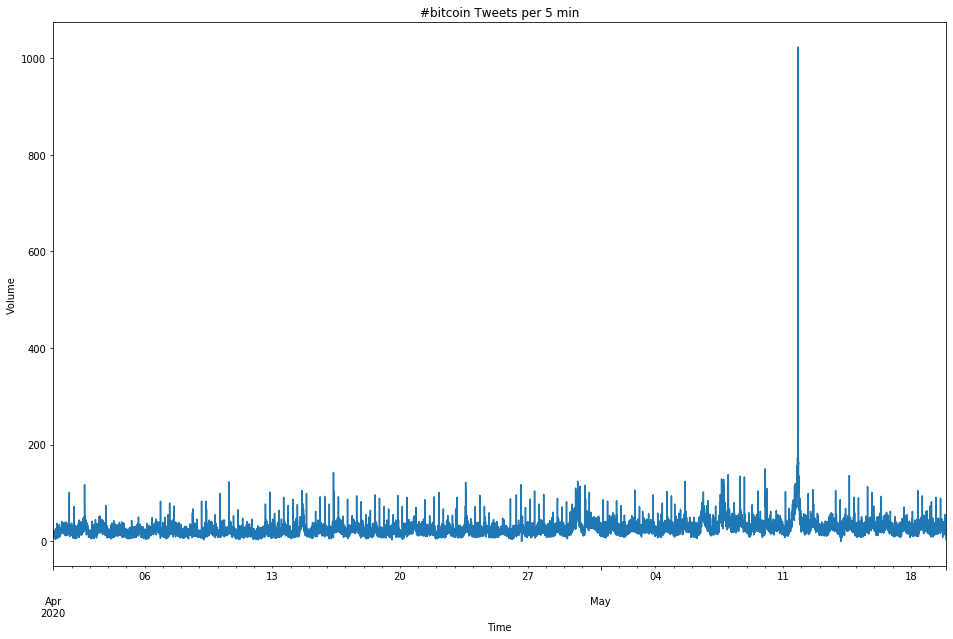

In [16]:
plot_start_date = '2020-04-01'

ax = tweet_volume['tweet_id'].loc[plot_start_date:].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Volume')
ax.set_title('#bitcoin Tweets per 5 min')

Investigate the spikes:

In [19]:
tweet_volume.sort_values(by='tweet_id', ascending=False).head()

,tweet_id,compound,smooth
created,,,
2020-05-11 19:25:00+00:00,1023,1023,197.265025
2020-05-11 19:30:00+00:00,579,579,226.629254
2020-05-11 19:35:00+00:00,372,372,237.811619
2020-05-11 19:40:00+00:00,240,240,237.979956
2020-05-11 19:45:00+00:00,224,224,236.904575


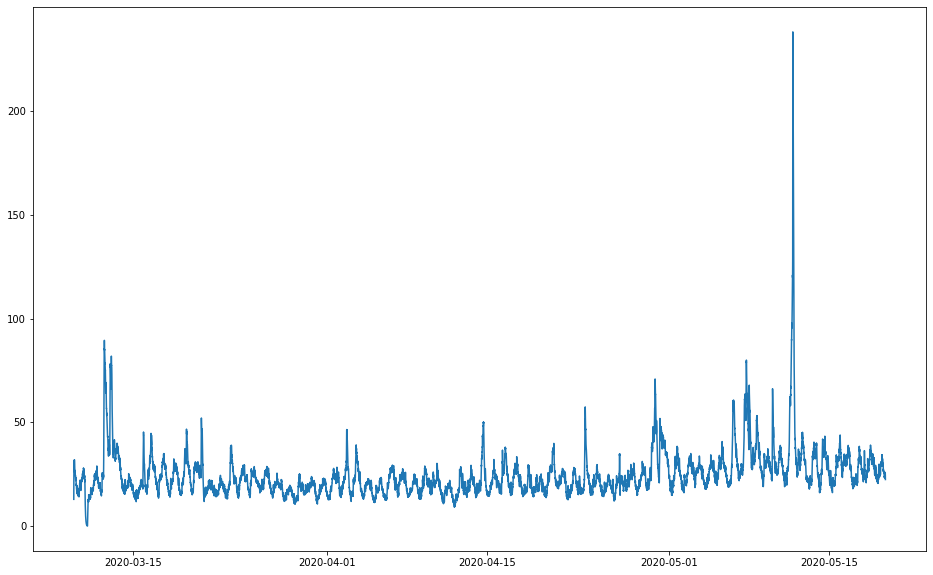

In [20]:
tweet_volume['smooth'] = tweet_volume['tweet_id'].ewm(12).mean()
plt.plot(tweet_volume['smooth'])

### Tweet sentiment time series

In [21]:
sentiment_time = tweet_grouped.mean()
sentiment_time

,compound
created,
2020-03-09 19:40:00+00:00,0.261085
2020-03-09 19:45:00+00:00,0.194479
2020-03-09 19:50:00+00:00,0.176573
2020-03-09 19:55:00+00:00,0.081617
2020-03-09 20:00:00+00:00,0.050008
...,...
2020-05-19 22:00:00+00:00,0.028718
2020-05-19 22:05:00+00:00,0.119500
2020-05-19 22:10:00+00:00,0.127071


Text(0, 0.5, 'Mean Sentiment Rating')

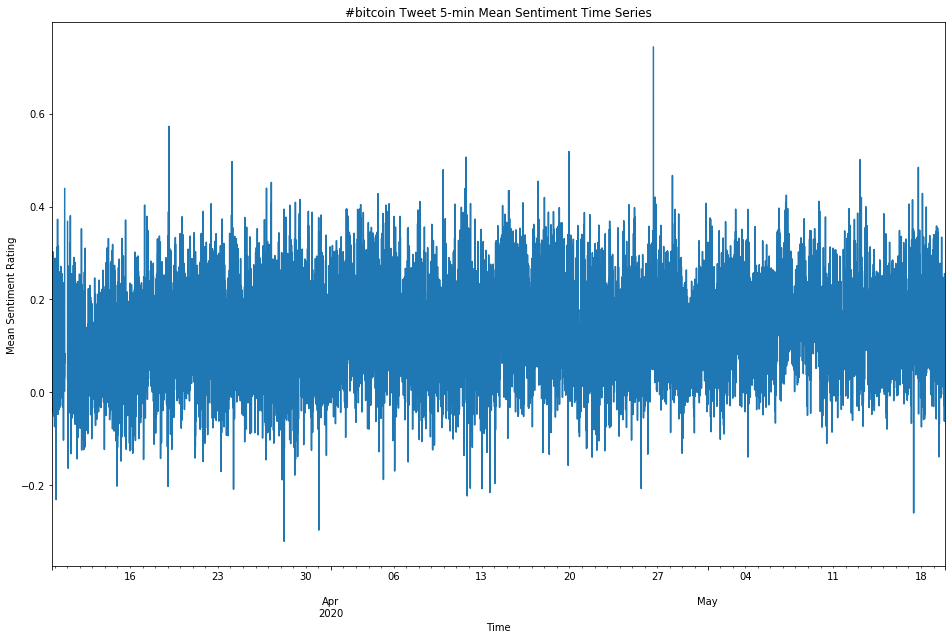

In [22]:
sentiment_time['compound'].plot()
plt.title('#bitcoin Tweet 5-min Mean Sentiment Time Series')
plt.xlabel('Time')
plt.ylabel('Mean Sentiment Rating')

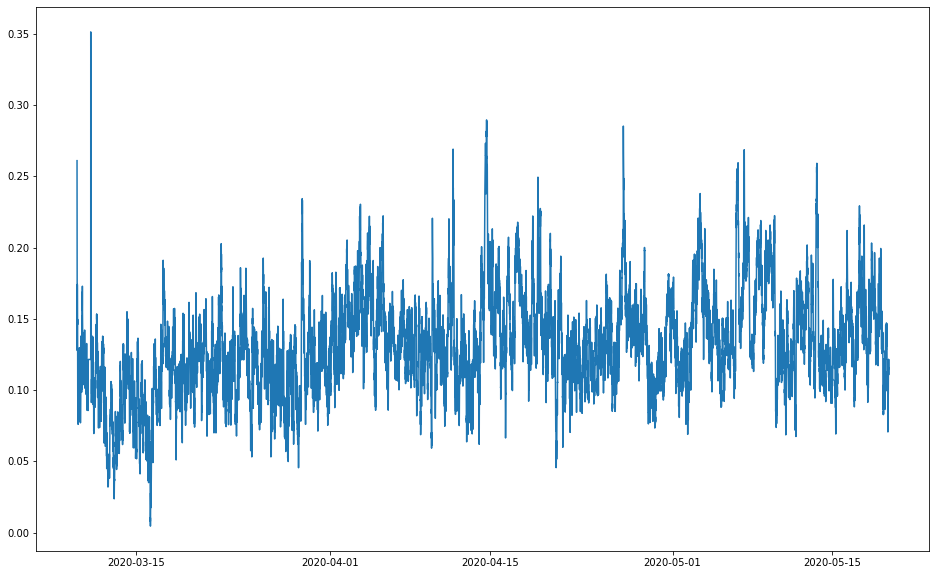

In [23]:
sentiment_time['smooth'] = sentiment_time['compound'].ewm(12).mean()
plt.plot(sentiment_time['smooth'])

### Google Trends Data

In [24]:
from pytrends.request import TrendReq

In [25]:
focus_words = ['bitcoin']

pygt = TrendReq()
pygt.build_payload(kw_list=focus_words)

interest_over_time_df = pygt.interest_over_time()
del interest_over_time_df['isPartial']
interest_over_time_df

,bitcoin
date,
2015-05-24,2
2015-05-31,2
2015-06-07,2
2015-06-14,2
2015-06-21,2
...,...
2020-04-19,12
2020-04-26,16
2020-05-03,18


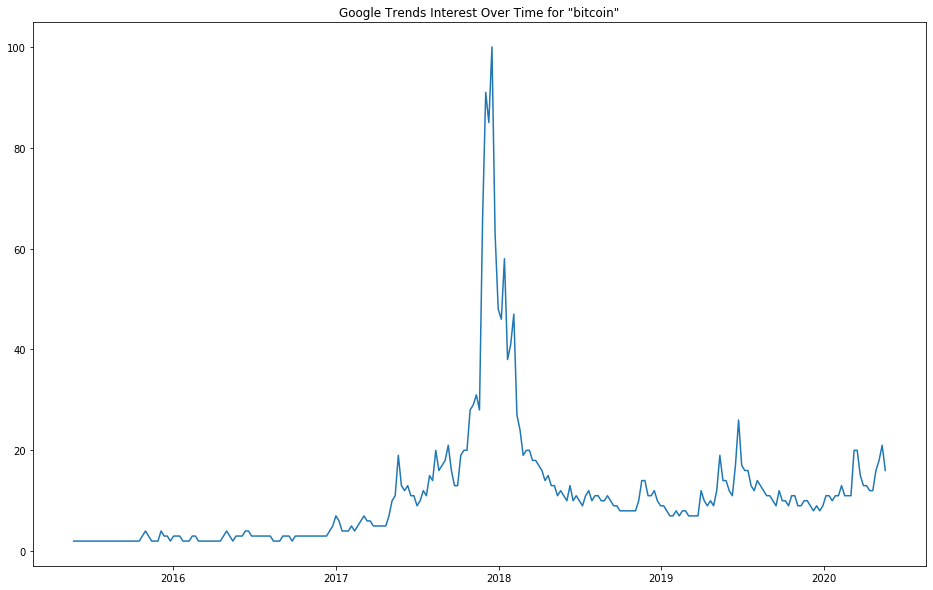

In [26]:
plot = plt.plot(interest_over_time_df)
plt.title('Google Trends Interest Over Time for "bitcoin"')
plt.show()

In [27]:
historical_hourly_interest_df = pygt.get_historical_interest(focus_words, year_start=2020, month_start=4, day_start=17, hour_start=0, year_end=2020, month_end=5, day_end=19, hour_end=0, cat=0, geo='', gprop='').drop('isPartial', axis=1).reset_index().drop_duplicates('date').set_index('date')
historical_hourly_interest_df

The request failed: Google returned a response with code 500.


,bitcoin
date,
2020-04-17 00:00:00,80
2020-04-17 01:00:00,76
2020-04-17 02:00:00,76
2020-04-17 03:00:00,76
2020-04-17 04:00:00,82
...,...
2020-05-18 20:00:00,85
2020-05-18 21:00:00,90
2020-05-18 22:00:00,86


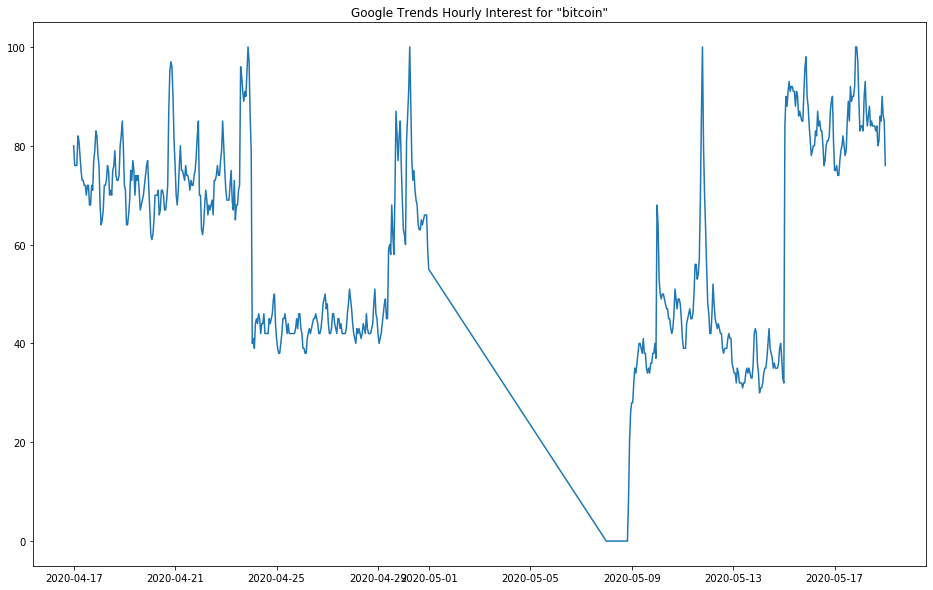

In [28]:
plot = plt.plot(historical_hourly_interest_df)
plt.title('Google Trends Hourly Interest for "bitcoin"')
plt.show()

In [ ]:
rq = requests.get('https://trends.google.com/trends/api/widgetdata/multiline?hl=en-GB&tz=-60&req=%7B%22time%22:%222020-05-02T17%5C%5C:04%5C%5C:57+2020-05-05T17%5C%5C:04%5C%5C:57%22,%22resolution%22:%22EIGHT_MINUTE%22,%22locale%22:%22en-GB%22,%22comparisonItem%22:%5B%7B%22geo%22:%7B%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22BROAD%22,%22value%22:%22bitcoin%22%7D%5D%7D%7D%5D,%22requestOptions%22:%7B%22property%22:%22%22,%22backend%22:%22CM%22,%22category%22:0%7D%7D&token=APP6_UEAAAAAXrLuOb-aOlX32UFLI6M5qP76vAS0v6mG&tz=-60')

In [ ]:
print(rq.content.decode())

Some issues with this data.

Upsample with linear interpolation to five minute intervals to match other data series.

In [ ]:
gtrend_5min_df = pd.DataFrame(historical_hourly_interest_df.bitcoin.resample('5min').interpolate(method='linear'))
gtrend_5min_df.index = gtrend_5min_df.index.tz_localize('UTC')
gtrend_5min_df

### Bitcoin price index data

In [29]:
import requests
from io import StringIO

In [30]:
btc_index_dbit_data_1 = requests.get('https://www.deribit.com/static/csv/2020-04_btc_usd_price_index.csv').content.decode()
btc_index_dbit_data_2 = requests.get('https://www.deribit.com/static/csv/2020-05_btc_usd_price_index.csv').content.decode()

In [31]:
btc_index_dbit_df = pd.read_csv(StringIO(btc_index_dbit_data_1), skiprows=1).append(pd.read_csv(StringIO(btc_index_dbit_data_2), skiprows=1))
btc_index_dbit_df['Date and Time'] = pd.to_datetime(btc_index_dbit_df['Date and Time'], format='%Y-%m-%d %H:%M:%S')
btc_index_dbit_df = btc_index_dbit_df.set_index('Date and Time').tz_localize('UTC', level=0)
btc_index_dbit_df

,Price
Date and Time,
2020-04-01 00:00:00+00:00,6423.38
2020-04-01 00:00:01+00:00,6423.79
2020-04-01 00:00:02+00:00,6423.72
2020-04-01 00:00:03+00:00,6423.88
2020-04-01 00:00:04+00:00,6424.28
...,...
2020-05-19 22:32:38+00:00,9727.44
2020-05-19 22:32:39+00:00,9727.68
2020-05-19 22:32:40+00:00,9727.40


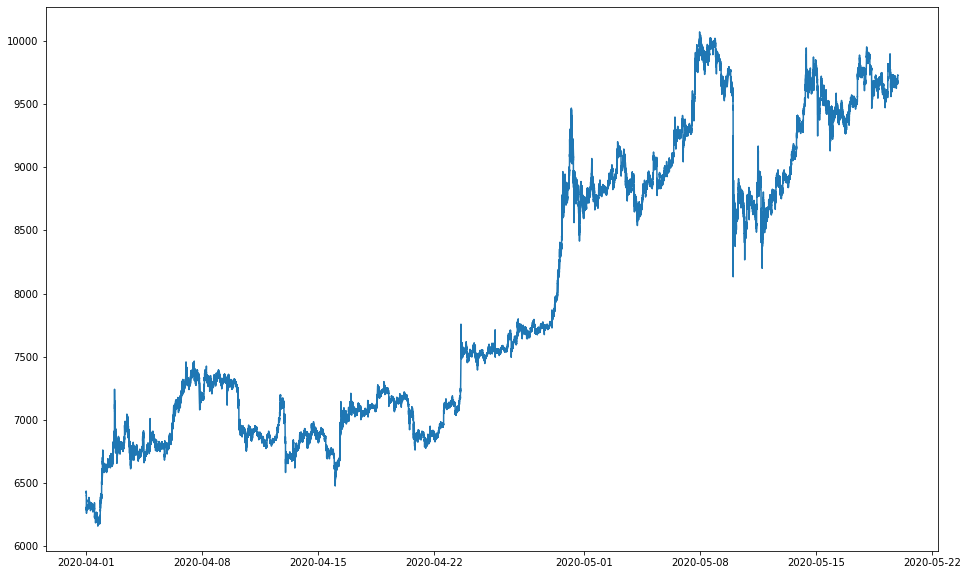

In [32]:
plt.plot(btc_index_dbit_df)

### Volatility index data

In [33]:
indices_df = pd.read_csv('/home/fp361/bitfear/vix-implementation/volatility_dataset.csv')
indices_df['timestamp'] = pd.to_datetime(indices_df['timestamp'])
indices_df = indices_df.set_index('timestamp').tz_localize('UTC', level=0)
indices_df

,vxbt,gvxbt,avxbt,index_usd
timestamp,,,,
2020-04-17 08:35:00+00:00,1.043923,0.796232,0.000114,NaN
2020-04-17 08:40:00+00:00,1.043290,0.796363,0.000114,NaN
2020-04-17 08:45:00+00:00,1.044881,0.791626,0.000113,NaN
2020-04-17 08:50:00+00:00,1.041748,0.799744,0.000114,NaN
2020-04-17 08:55:00+00:00,1.034267,0.803266,0.000115,NaN
...,...,...,...,...
2020-05-19 21:34:00+00:00,1.018213,1.010987,0.000107,9699.39
2020-05-19 21:35:00+00:00,1.018269,1.010971,0.000107,9699.09
2020-05-19 21:36:00+00:00,1.018089,1.010622,0.000107,9697.71


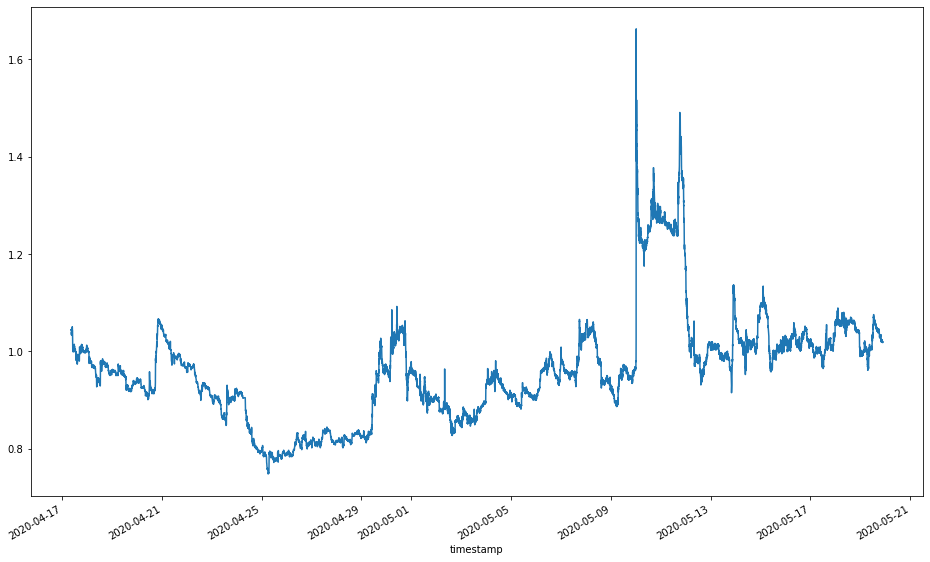

In [34]:
indices_df['vxbt'].plot()

***

## Regression Models

### Data Cleaning

Select a common time range where each series has clean data available:

In [35]:
start_date = max([df.index[0] for df in [btc_index_dbit_df, sentiment_time, tweet_volume, indices_df]])#, gtrend_5min_df]])
end_date = min([df.index[-1] for df in [btc_index_dbit_df, sentiment_time, tweet_volume, indices_df]])#, gtrend_5min_df]])

print(f'Start: {start_date}')
print(f'End: {end_date}')

series_btc = btc_index_dbit_df.loc[start_date:end_date]
series_sentiment = sentiment_time['smooth'].loc[start_date:end_date]
series_volume = tweet_volume.filter(['smooth']).loc[start_date:end_date]
series_indices = indices_df['vxbt'].loc[start_date:end_date]
#series_gtrend = gtrend_5min_df['bitcoin'].loc[start_date:end_date]

Start: 2020-04-17 08:35:00+00:00
End: 2020-05-19 21:38:00+00:00


In [ ]:
series_sentiment

Plot narrowed down time series:

NameError: name 'series_gtrend' is not defined

/home/fp361/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


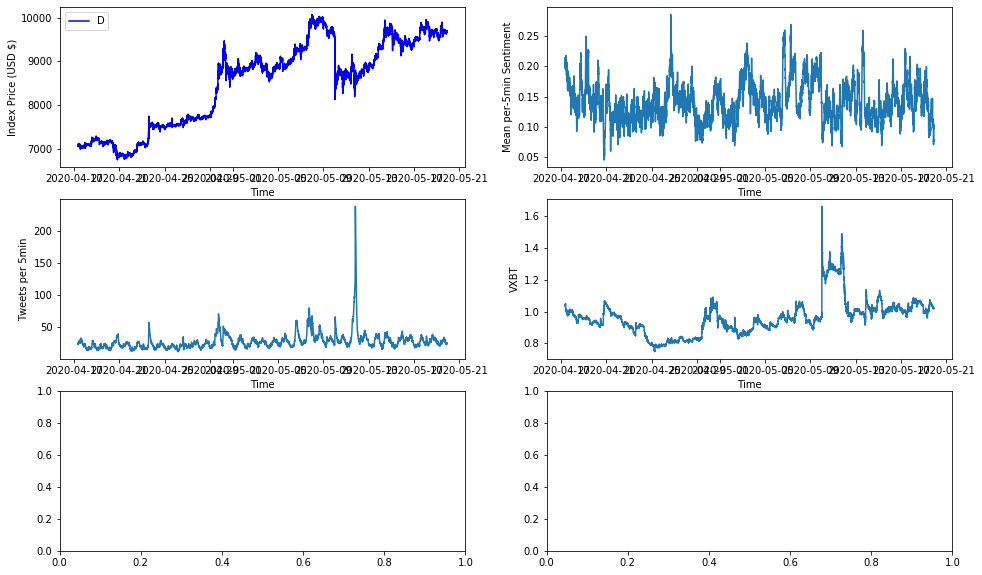

In [36]:
fig, ax =  plt.subplots(3,2)

ax[0][0].plot(series_btc, color='blue')
ax[0][0].legend('Deribit')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Index Price (USD $)')

ax[0][1].plot(series_sentiment)
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('Mean per-5min Sentiment')

ax[1][0].plot(series_volume)
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Tweets per 5min')

ax[1][1].plot(series_indices)
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('VXBT')

ax[2][0].plot(series_gtrend)
ax[2][0].set_xlabel('Time')
ax[2][0].set_ylabel('Trend Value')

fig.suptitle('Time Series')

Discard Google Trends data for the time being. Need to determine what is causing the strange gaps.

In [37]:
#data = pd.DataFrame(series_indices).merge(series_volume, left_index=True, right_index=True).merge(series_sentiment, left_index=True, right_index=True).merge(series_gtrend, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
data = pd.DataFrame(series_indices).merge(series_volume, left_index=True, right_index=True).merge(series_sentiment, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
#data.columns = ['vxbt', 'tweet_vol', 'sentiment', 'gtrend', 'index']
data.columns = ['vxbt', 'tweet_vol', 'sentiment', 'index']
data = data.sort_index(ascending=False)
data

,vxbt,tweet_vol,sentiment,index
2020-05-19 21:35:00+00:00,1.018269,25.131136,0.099288,9698.98
2020-05-19 21:30:00+00:00,1.019175,25.308731,0.097043,9695.95
2020-05-19 21:25:00+00:00,1.019261,24.917792,0.103194,9682.75
2020-05-19 21:20:00+00:00,1.018875,25.160941,0.097639,9679.21
2020-05-19 21:15:00+00:00,1.018623,25.007686,0.100298,9678.93
...,...,...,...,...
2020-04-17 08:55:00+00:00,1.034267,23.174645,0.213473,7067.54
2020-04-17 08:50:00+00:00,1.041748,23.189199,0.208757,7064.75
2020-04-17 08:45:00+00:00,1.044881,23.121632,0.204792,7078.24
2020-04-17 08:40:00+00:00,1.043290,23.548435,0.197086,7075.52


In [409]:
# Backup in case of future kernel crash
data.to_csv('data.csv')

In [ ]:
# Restore in case of kernel crash
data = pd.read_csv('data.csv')
data['timestamp'] = pd.to_datetime(data['Unnamed: 0'])
data = data.drop('Unnamed: 0', axis=1).set_index('timestamp')
data

### Linear Regression

In [39]:
samples_in_window = 10
X = []
y = []

for i in range(1, data.shape[0] - samples_in_window):
    X.append(data.iloc[i:i + samples_in_window, :].to_numpy().ravel())
    
y = data['index'].iloc[0:data.shape[0] - samples_in_window - 1].to_numpy()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg = linreg.fit(X, y)

In [41]:
print(linreg.intercept_)

feature_names = [f'{data.columns[i % len(data.columns)]},t-{i//len(data.columns)+1}' for i, coeff in enumerate(linreg.coef_)]
print(json.dumps(dict(zip(feature_names, linreg.coef_)), indent=1))

4.18186187165702
{
 "vxbt,t-1": -197.09381082356091,
 "tweet_vol,t-1": 0.14853744533778632,
 "sentiment,t-1": 10.378321645253404,
 "index,t-1": 0.9963589747280689,
 "vxbt,t-2": 495.596258312101,
 "tweet_vol,t-2": -1.0420460738368376,
 "sentiment,t-2": -20.022253005735173,
 "index,t-2": -0.02308283114921429,
 "vxbt,t-3": -251.98438291391065,
 "tweet_vol,t-3": 1.3351992065629783,
 "sentiment,t-3": 82.85325674653322,
 "index,t-3": 0.04085589887233774,
 "vxbt,t-4": -123.86145189017921,
 "tweet_vol,t-4": -0.38888289127537756,
 "sentiment,t-4": -75.69633655363934,
 "index,t-4": -0.035603079742970375,
 "vxbt,t-5": 145.03369603779726,
 "tweet_vol,t-5": 0.30284363703104605,
 "sentiment,t-5": 8.946119808446273,
 "index,t-5": -0.002305485492623756,
 "vxbt,t-6": 51.143790092511495,
 "tweet_vol,t-6": 0.46163295015633765,
 "sentiment,t-6": -21.452147402502884,
 "index,t-6": 0.004920284866992487,
 "vxbt,t-7": -169.8534949292868,
 "tweet_vol,t-7": -0.9627455911961625,
 "sentiment,t-7": 68.543703240471

#### Metrics

In [42]:
from sklearn import metrics

output = pd.DataFrame(index=data.iloc[0:len(y)].index)
output['actual'] = data['index'].loc[:output.index[-1]]
output['predicted'] = linreg.predict(X)

print('RMSE {}'.format(np.sqrt(metrics.mean_squared_error(output['actual'], output['predicted']))))

RMSE 21.483314042352273


In [43]:
output

,actual,predicted
2020-05-19 21:35:00+00:00,9698.98,9696.853531
2020-05-19 21:30:00+00:00,9695.95,9683.432581
2020-05-19 21:25:00+00:00,9682.75,9683.843445
2020-05-19 21:20:00+00:00,9679.21,9677.477568
2020-05-19 21:15:00+00:00,9678.93,9691.201574
...,...,...
2020-04-17 09:50:00+00:00,7131.58,7122.722679
2020-04-17 09:45:00+00:00,7120.48,7118.977540
2020-04-17 09:40:00+00:00,7120.83,7115.846509
2020-04-17 09:35:00+00:00,7116.57,7091.732766


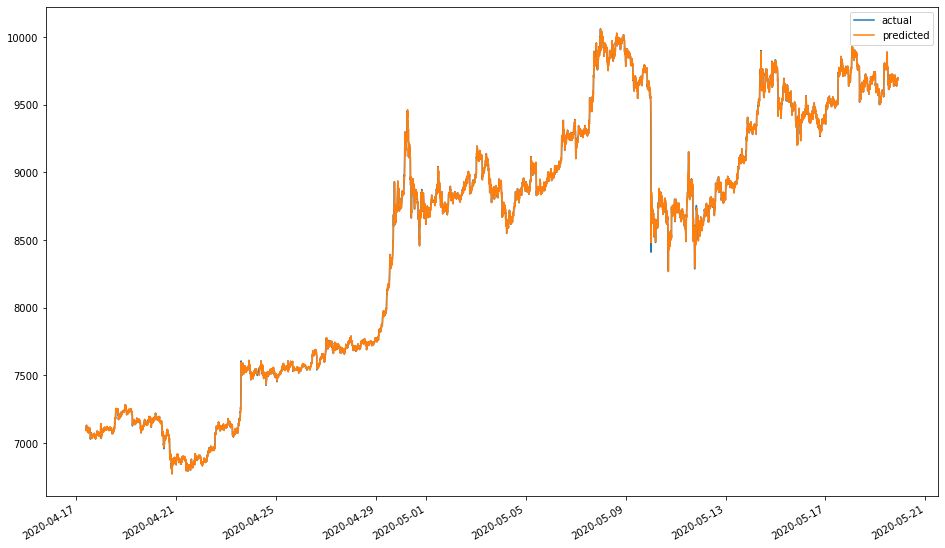

In [44]:
output.plot()

### Permutation Importance

In [45]:
from sklearn.inspection import permutation_importance

In [46]:
importances = permutation_importance(linreg, X, y)

importances_mean = dict(zip(feature_names, importances['importances_mean']))
sorted_im_mean = {k: v for k, v in sorted(importances_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_mean, indent=1))

{
 "index,t-1": 1.9857303860876279,
 "vxbt,t-2": 0.006397544926535814,
 "index,t-3": 0.003333208768209439,
 "index,t-4": 0.0025417436648167866,
 "index,t-7": 0.0017849696466116782,
 "vxbt,t-3": 0.0016516225307560584,
 "index,t-2": 0.0010695135134352717,
 "vxbt,t-1": 0.0010098863197765874,
 "vxbt,t-7": 0.000750335795813073,
 "tweet_vol,t-3": 0.0006976317456386827,
 "vxbt,t-5": 0.0005486829144925931,
 "tweet_vol,t-2": 0.00042692500396313005,
 "vxbt,t-4": 0.0003984837700136801,
 "tweet_vol,t-7": 0.00036505308523582247,
 "tweet_vol,t-9": 0.00018730464882568131,
 "index,t-9": 0.00012664798633861275,
 "tweet_vol,t-6": 8.290212876402859e-05,
 "vxbt,t-6": 6.845367848653527e-05,
 "tweet_vol,t-4": 5.9671450514842125e-05,
 "index,t-6": 4.768217975135158e-05,
 "tweet_vol,t-5": 3.555134603328014e-05,
 "sentiment,t-8": 3.24265976785032e-05,
 "tweet_vol,t-8": 2.9555048034635156e-05,
 "tweet_vol,t-10": 2.9409751448072897e-05,
 "sentiment,t-9": 2.770763347403893e-05,
 "index,t-8": 1.681683694190195e-05

## Predictive signals for VXBT

### Linear Regression

In [47]:
samples_in_window = 10
X_vxbt = []
y_vxbt = []

for i in range(1, data.shape[0] - samples_in_window):
    X_vxbt.append(data.iloc[i:i + samples_in_window, :].to_numpy().ravel())
    
y_vxbt = data['vxbt'].iloc[0:data.shape[0] - samples_in_window - 1].to_numpy()

In [48]:
linreg_vxbt = LinearRegression()
linreg_vxbt = linreg.fit(X_vxbt, y_vxbt)

print(linreg_vxbt.intercept_)

feature_names = [f'{data.columns[i % len(data.columns)]},t-{i//len(data.columns)+1}' for i, coeff in enumerate(linreg_vxbt.coef_)]
print(json.dumps(dict(zip(feature_names, linreg_vxbt.coef_)), indent=1))

0.0009164493513892369
{
 "vxbt,t-1": 1.140915841689451,
 "tweet_vol,t-1": 0.0003061389274841612,
 "sentiment,t-1": -0.009354216676112304,
 "index,t-1": -1.477107174110351e-05,
 "vxbt,t-2": -0.1410608427607602,
 "tweet_vol,t-2": -0.00012495991468443305,
 "sentiment,t-2": 0.009219611655600875,
 "index,t-2": 2.3289001797414655e-05,
 "vxbt,t-3": 0.06363753805455087,
 "tweet_vol,t-3": -0.00026632217531481674,
 "sentiment,t-3": -0.013567948052440137,
 "index,t-3": -8.97208521259906e-06,
 "vxbt,t-4": -0.013892904128801708,
 "tweet_vol,t-4": 0.00011835177764914997,
 "sentiment,t-4": 0.013597592628103143,
 "index,t-4": -1.3065335876550752e-06,
 "vxbt,t-5": -0.03589821747133932,
 "tweet_vol,t-5": -0.00010198173430283681,
 "sentiment,t-5": -0.0035210827394444857,
 "index,t-5": -1.9275350560186164e-06,
 "vxbt,t-6": -0.07342736868830425,
 "tweet_vol,t-6": -9.506556244393363e-05,
 "sentiment,t-6": -0.009482700664473829,
 "index,t-6": 1.0285024095738097e-05,
 "vxbt,t-7": 0.060871597250572756,
 "tweet

#### Metrics

In [49]:
output_vxbt = pd.DataFrame(index=data.iloc[0:len(y_vxbt)].index)
output_vxbt['actual'] = data['vxbt'].loc[:output.index[-1]]
output_vxbt['predicted'] = linreg_vxbt.predict(X_vxbt)

print('RMSE {}'.format(np.sqrt(metrics.mean_squared_error(output_vxbt['actual'], output_vxbt['predicted']))))

RMSE 0.005331643456149971


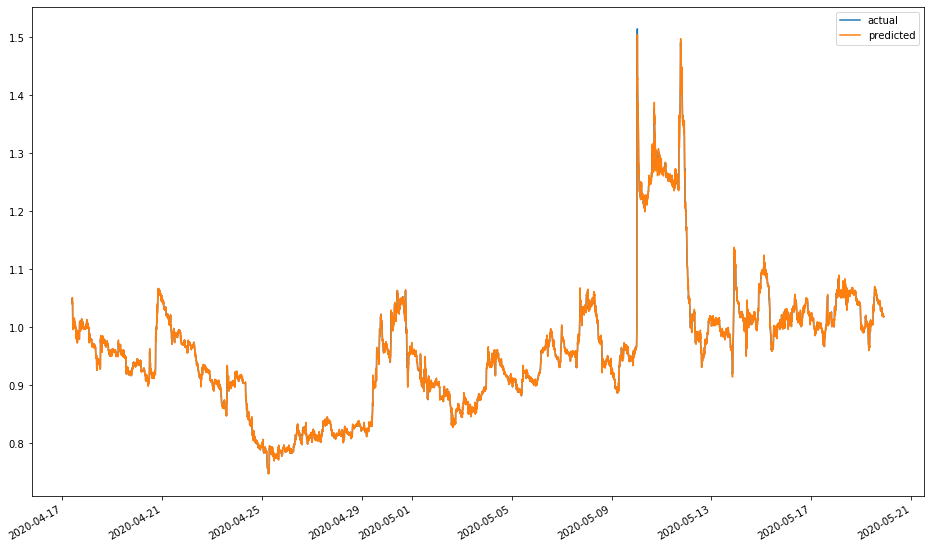

In [50]:
output_vxbt.plot()

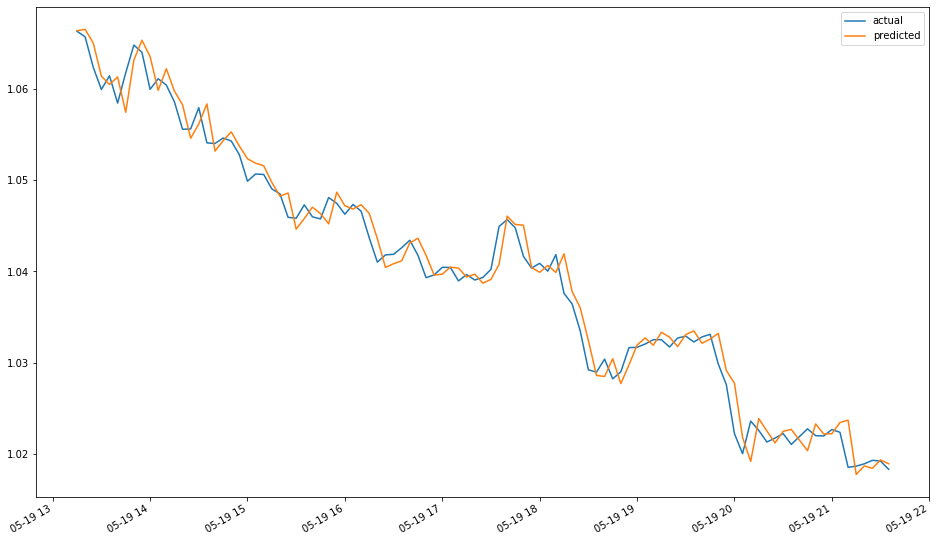

In [53]:
output_vxbt.iloc[:100].plot()

## Classification: predictive signals for VXBT

### Directionalise

Assign each signal a direction for each time interval (http://users.auth.gr/passalis/assets/pdf/confs/2017_CBI_CNNLOB.pdf)

In [382]:
import seaborn as sns
import datetime

from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

In [54]:
norm_data = (data-data.min())/(data.max()-data.min())
norm_data['vxbt_prev'] = norm_data['vxbt'].shift(-1)
norm_data['tweet_vol_prev'] = norm_data['tweet_vol'].shift(-1)
norm_data['sentiment_prev'] = norm_data['sentiment'].shift(-1)
norm_data['index_prev'] = norm_data['index'].shift(-1)
norm_data

,vxbt,tweet_vol,sentiment,index,vxbt_prev,tweet_vol_prev,sentiment_prev,index_prev
2020-05-19 21:35:00+00:00,0.352868,0.057420,0.224003,0.890179,0.354050,0.058207,0.214640,0.889257
2020-05-19 21:30:00+00:00,0.354050,0.058207,0.214640,0.889257,0.354163,0.056476,0.240292,0.885241
2020-05-19 21:25:00+00:00,0.354163,0.056476,0.240292,0.885241,0.353659,0.057552,0.217122,0.884164
2020-05-19 21:20:00+00:00,0.353659,0.057552,0.217122,0.884164,0.353329,0.056874,0.228212,0.884079
2020-05-19 21:15:00+00:00,0.353329,0.056874,0.228212,0.884079,0.353160,0.061305,0.221314,0.886848
...,...,...,...,...,...,...,...,...
2020-04-17 08:55:00+00:00,0.373752,0.048756,0.700195,0.089486,0.383518,0.048821,0.680527,0.088637
2020-04-17 08:50:00+00:00,0.383518,0.048821,0.680527,0.088637,0.387608,0.048521,0.663993,0.092741
2020-04-17 08:45:00+00:00,0.387608,0.048521,0.663993,0.092741,0.385531,0.050411,0.631855,0.091914
2020-04-17 08:40:00+00:00,0.385531,0.050411,0.631855,0.091914,0.386357,0.049876,0.628703,0.091993


In [265]:
def assign_vxbt_direction(row, threshold):
    if row.vxbt_prev > row.vxbt + threshold:
        return 1
    elif row.vxbt_prev < row.vxbt - threshold:
        return -1
    else:
        return 0

def assign_direction(row, threshold):
    if row[1] > row[0] * (1 + threshold):
        return 1
    elif row[1] < row[0] * (1 - threshold):
        return -1
    else:
        return 0

In [282]:
t_min = 0.01
t_max = 0.03
t_step = 0.001

t_list = list()
t_avg = list()
for t_val in np.arange(t_min, t_max, t_step):
    t_list.append(t_val)
    norm_data['tweet_vol_direction'] = norm_data[['tweet_vol', 'tweet_vol_prev']].apply(assign_direction, axis=1, threshold=t_val)
    t_avg.append(abs(norm_data['tweet_vol_direction'].value_counts() - len(norm_data['tweet_vol_direction'])/3).mean())

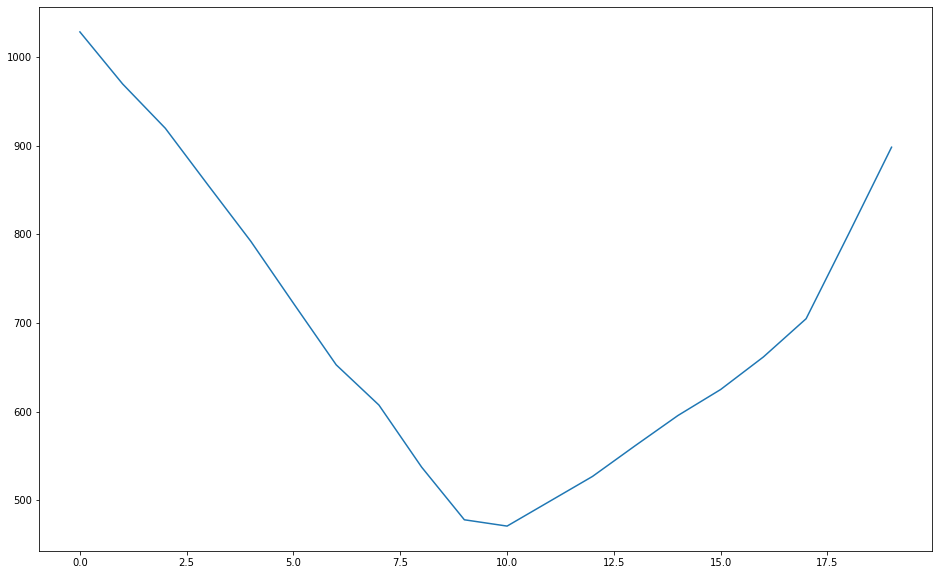

In [283]:
plt.plot(t_avg)

In [284]:
t_optimal = t_list[t_avg.index(min(t_avg))]
t_optimal

0.01999999999999999

In [317]:
# We should use a window - try a window of 50 samples

# We should as a first pass, just try to use the previous sequence of the `vxbt_direction` to predice the next `vxbt_direction`
# For this uni-variate timeseries prediction we should check the class distribution (Histogram of the classes & tune the threshold so they are equal)
# We then should try to predict this using LogisitcRegression & Plot the confusion matrix to see the prediction imblanaces

# We then would want to extend this to multi-variate, signals, still including the `vxbt_direction` previous values

norm_data['vxbt_direction'] = norm_data[['vxbt', 'vxbt_prev']].apply(assign_vxbt_direction, axis=1, threshold=0.0011)
norm_data['tweet_vol_direction'] = norm_data[['tweet_vol', 'tweet_vol_prev']].apply(assign_direction, axis=1, threshold=0.0200)
norm_data['sentiment_direction'] = norm_data[['sentiment', 'sentiment_prev']].apply(assign_direction, axis=1, threshold=0.0274)
norm_data['index_direction'] = norm_data[['index', 'index_prev']].apply(assign_direction, axis=1, threshold=0.0036)

direction_df = norm_data.copy().filter(['vxbt_direction', 'tweet_vol_direction', 'sentiment_direction', 'index_direction'])
direction_df

,vxbt_direction,tweet_vol_direction,sentiment_direction,index_direction
2020-05-19 21:35:00+00:00,1,0,-1,0
2020-05-19 21:30:00+00:00,0,-1,1,-1
2020-05-19 21:25:00+00:00,0,0,-1,0
2020-05-19 21:20:00+00:00,0,0,1,0
2020-05-19 21:15:00+00:00,0,1,-1,0
...,...,...,...,...
2020-04-17 08:55:00+00:00,1,0,-1,-1
2020-04-17 08:50:00+00:00,1,0,0,1
2020-04-17 08:45:00+00:00,-1,1,-1,-1
2020-04-17 08:40:00+00:00,0,0,0,0


In [307]:
print(direction_df['vxbt_direction'].value_counts())
print(direction_df['tweet_vol_direction'].value_counts())
print(direction_df['sentiment_direction'].value_counts())
print(direction_df['index_direction'].value_counts())

 1    3246
 0    3036
-1    2957
Name: vxbt_direction, dtype: int64
 1    3695
 0    3171
-1    2373
Name: tweet_vol_direction, dtype: int64
 1    3167
 0    3081
-1    2991
Name: sentiment_direction, dtype: int64
-1    3222
 0    3061
 1    2956
Name: index_direction, dtype: int64


Backup in case of future kernel crash

In [408]:
direction_df.to_csv('direction.csv', index=False)

### Data prep

In [309]:
from sklearn.linear_model import LogisticRegression

In [318]:
logreg_df = direction_df.copy()
logreg_df['vxbt_direction_next'] = logreg_df['vxbt_direction'].shift(1)
logreg_df = logreg_df.dropna()
logreg_df

,vxbt_direction,tweet_vol_direction,sentiment_direction,index_direction,vxbt_direction_next
2020-05-19 21:30:00+00:00,0,-1,1,-1,1.0
2020-05-19 21:25:00+00:00,0,0,-1,0,0.0
2020-05-19 21:20:00+00:00,0,0,1,0,0.0
2020-05-19 21:15:00+00:00,0,1,-1,0,0.0
2020-05-19 21:10:00+00:00,1,0,-1,0,0.0
...,...,...,...,...,...
2020-04-17 08:55:00+00:00,1,0,-1,-1,-1.0
2020-04-17 08:50:00+00:00,1,0,0,1,1.0
2020-04-17 08:45:00+00:00,-1,1,-1,-1,1.0
2020-04-17 08:40:00+00:00,0,0,0,0,-1.0


In [325]:
test_train_ratio = 0.1
split_index = int(direction_df.shape[0] * 0.1)

X_test = logreg_df[['tweet_vol_direction', 'sentiment_direction', 'index_direction', 'vxbt_direction']].iloc[:split_index]
y_test = logreg_df[['vxbt_direction_next']].iloc[:split_index]

X_train = logreg_df[['tweet_vol_direction', 'sentiment_direction', 'index_direction', 'vxbt_direction']].iloc[split_index:]
y_train = logreg_df[['vxbt_direction_next']].iloc[split_index:]

X_train

,tweet_vol_direction,sentiment_direction,index_direction,vxbt_direction
2020-05-16 16:10:00+00:00,0,-1,0,1
2020-05-16 16:05:00+00:00,-1,-1,0,0
2020-05-16 16:00:00+00:00,-1,1,-1,0
2020-05-16 15:55:00+00:00,-1,0,0,0
2020-05-16 15:50:00+00:00,0,1,1,-1
...,...,...,...,...
2020-04-17 08:55:00+00:00,0,-1,-1,1
2020-04-17 08:50:00+00:00,0,0,1,1
2020-04-17 08:45:00+00:00,1,-1,-1,-1
2020-04-17 08:40:00+00:00,0,0,0,0


In [326]:
y_train

,vxbt_direction_next
2020-05-16 16:10:00+00:00,0.0
2020-05-16 16:05:00+00:00,1.0
2020-05-16 16:00:00+00:00,0.0
2020-05-16 15:55:00+00:00,0.0
2020-05-16 15:50:00+00:00,0.0
...,...
2020-04-17 08:55:00+00:00,-1.0
2020-04-17 08:50:00+00:00,1.0
2020-04-17 08:45:00+00:00,1.0
2020-04-17 08:40:00+00:00,-1.0


### Models

#### Logistic Regression: Univariate

In [392]:
samples_in_window = 50

X_train_window_uv = []
y_train_window_uv = []

X_test_window_uv = []
y_test_window_uv = []

for i in range(0, X_train.shape[0] - samples_in_window):
    X_train_window_uv.append(X_train['vxbt_direction'].iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_train_window_uv = y_train['vxbt_direction_next'].iloc[0:y_train.shape[0] - samples_in_window].to_numpy()

for i in range(0, X_test.shape[0] - samples_in_window):
    X_test_window_uv.append(X_test['vxbt_direction'].iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_test_window_uv = y_test['vxbt_direction_next'].iloc[0:y_test.shape[0] - samples_in_window].to_numpy()

In [393]:
len(X_train_window_uv), len(y_train_window_uv), len(X_test_window_uv), len(y_test_window_uv)

(8265, 8265, 873, 873)

In [394]:
logreg_uv = LogisticRegression().fit(X_train_window_uv, y_train_window_uv)

y_test_window_predicted_uv = logreg_uv.predict(X_test_window_uv)

Accuracy : 34.24971363115693 

F1 Score : 33.12334275040979 

Confusion Matrix: 
 Predicted  -1   0    1
Actual                
-1         58  81  138
 0         54  88  155
 1         66  80  153


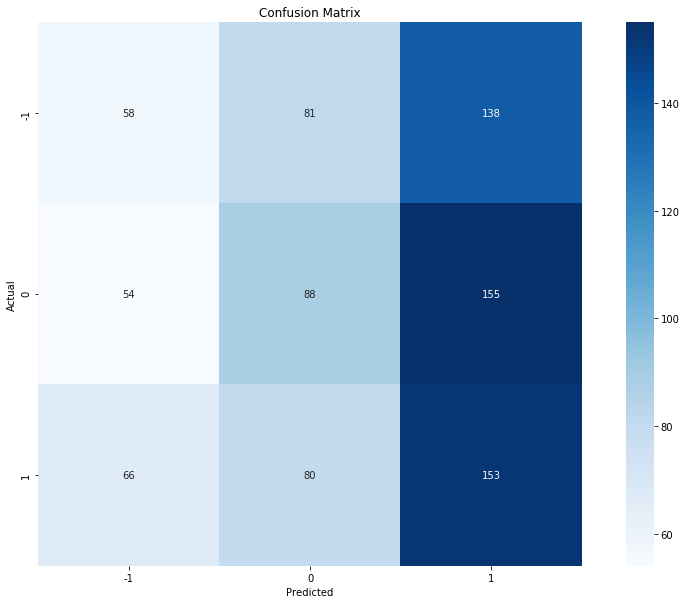

In [395]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_uv, y_test_window_predicted_uv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_uv, y_test_window_predicted_uv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_uv, y_test_window_predicted_uv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

#### Gradient Boosting Classifier: Univariate

In [396]:
gbc_uv = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_window_uv, y_train_window_uv)

y_test_window_predicted_uv = gbc_uv.predict(X_test_window_uv)

Accuracy : 36.884306987399775 

F1 Score : 36.453160392389904 

Confusion Matrix: 
 Predicted  -1    0    1
Actual                 
-1         70   83  124
 0         52  138  107
 1         76  109  114


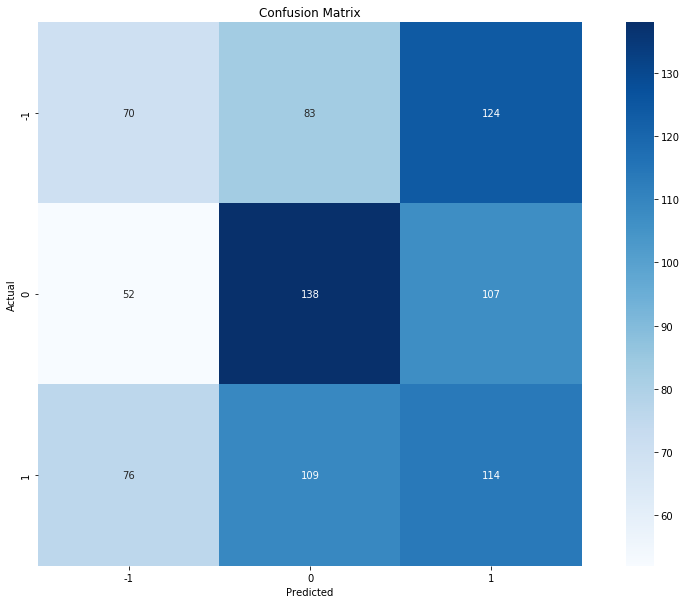

In [397]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_uv, y_test_window_predicted_uv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_uv, y_test_window_predicted_uv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_uv, y_test_window_predicted_uv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

#### Logistic Regression: Multivariate

In [398]:
samples_in_window = 50

X_train_window_mv = []
y_train_window_mv = []

X_test_window_mv = []
y_test_window_mv = []

for i in range(0, X_train.shape[0] - samples_in_window):
    X_train_window_mv.append(X_train.iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_train_window_mv = y_train['vxbt_direction_next'].iloc[0:y_train.shape[0] - samples_in_window].to_numpy()

for i in range(0, X_test.shape[0] - samples_in_window):
    X_test_window_mv.append(X_test.iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_test_window_mv = y_test['vxbt_direction_next'].iloc[0:y_test.shape[0] - samples_in_window].to_numpy()

In [400]:
len(X_train_window_mv), len(y_train_window_mv), len(X_test_window_mv), len(y_test_window_mv)

(8265, 8265, 873, 873)

In [404]:
logreg_mv = LogisticRegression().fit(X_train_window_mv, y_train_window_mv)

y_test_window_predicted_mv = logreg_mv.predict(X_test_window_mv)

Accuracy : 33.33333333333333 

F1 Score : 33.02188479119543 

Confusion Matrix: 
 Predicted  -1   0    1
Actual                
-1         83  75  119
 0         92  81  124
 1         89  83  127


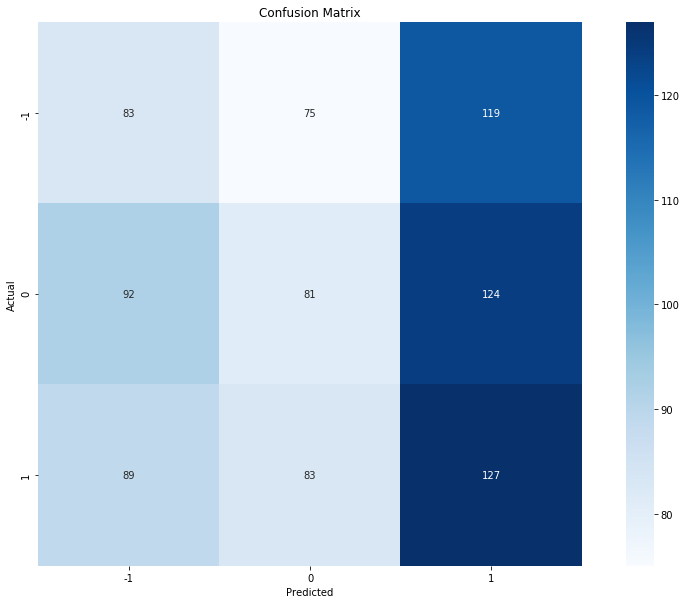

In [405]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_mv, y_test_window_predicted_mv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_mv, y_test_window_predicted_mv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_mv, y_test_window_predicted_mv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

#### Gradient Boosting Classifier: Multivariate

In [406]:
gbc_mv = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_window_mv, y_train_window_mv)

y_test_window_predicted_mv = gbc_mv.predict(X_test_window_mv)

Accuracy : 39.51890034364261 

F1 Score : 38.979597999107966 

Confusion Matrix: 
 Predicted  -1    0    1
Actual                 
-1         75   94  108
 0         57  145   95
 1         58  116  125


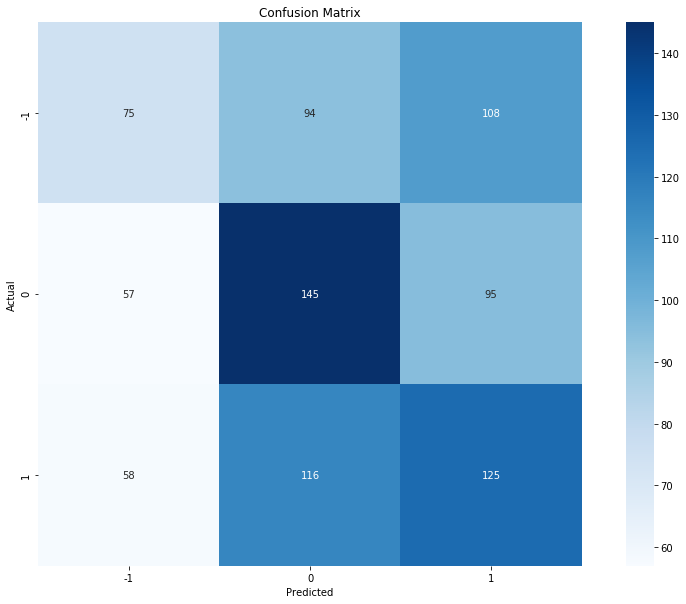

In [407]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_mv, y_test_window_predicted_mv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_mv, y_test_window_predicted_mv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_mv, y_test_window_predicted_mv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

***

### Notes

Algorithmically determine thresholds to equalise class distribution

10-90 test-train split

Evaluation metrics - confusion matrix - f1 score

Gradient boosting classifier

NN? - maybe out of scope.